# Deciding on community detection algorithms

In [1]:
import networkx as nx
from networkx.algorithms.community import quality

import pandas as pd
import community
import numpy as np
import matplotlib.pyplot as plt
import cdlib as cd
from cdlib import algorithms
from cdlib import evaluation

Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'wurlitzer', 'graph_tool', 'karateclub'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'ASLPAw', 'karateclub'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'infomap', 'wurlitzer'}


Import graph with references as nodes and edge weights based on Gmür (2003) CoCit-value

In [2]:
Ggmuer = nx.read_gexf("Ggmuer.gexf")

# Louvain: 
- guarantees that modularity cannot be increased by merging any two communities of the network and creates local optima (modularity: -1 to 1, a value close to 1 suggests a clear community structure with well-defined communities, a value close to 0 indicates a weak or no community structure, and a value close to -1 indicates a network divided into communities that are poorly separated or even overlapping)
- does not ! guarantee that modularity cannot be increased by moving a single node from one community to another
- might be slow for large networks


Modification of resolution parameter to find out how it affects the number of clusters:

In [21]:
coms = algorithms.louvain(Ggmuer, weight='weight', resolution=0.8, randomize=False) 
# resolution: higher values lead to smaller communities
# randomize: randomize the node evaluation order and get different partitions at each call

len(coms.communities)

evaluation.size(Ggmuer, coms)
evaluation.size(Ggmuer, coms, summary = False) 
# summary = False gives list of floats 
# # Size is the number of nodes in the community

[117,
 66,
 59,
 32,
 25,
 21,
 18,
 18,
 14,
 11,
 11,
 8,
 8,
 8,
 8,
 7,
 5,
 5,
 4,
 4,
 3,
 2,
 2,
 2,
 2]

Test with different resolutions and compare the results

In [19]:
clusters = [] # takes a few seconds to run

for resolution in np.linspace(0,1,20):
    coms = algorithms.louvain(Ggmuer, weight='weight', resolution = resolution, randomize=False)
    clusters.append(len(coms.communities))

clusters = np.array(clusters)
min_clusters_idx = np.argmin(clusters) # argmin returns the indices of the minimum values along an axis
min_resolution = np.linspace(0, 1, 20)[min_clusters_idx]

print("Minimum clusters:", clusters[min_clusters_idx])
print("Resolution with minimal clusters:", min_resolution)

Minimum clusters: 7
Resolution with minimal clusters: 0.8421052631578947


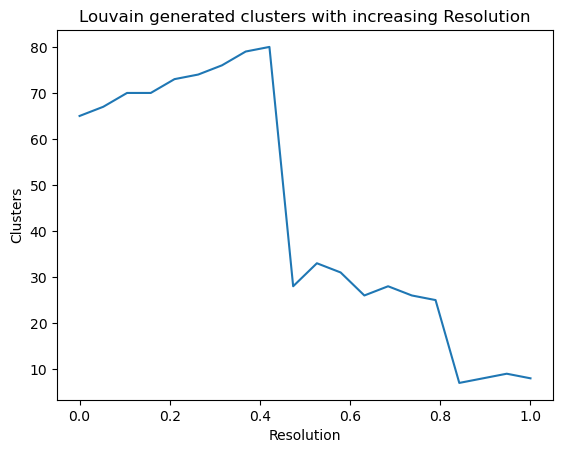

In [20]:
x = np.linspace(0, 1, 20)
y = clusters

plt.plot(x, y)
plt.xlabel('Resolution')
plt.ylabel('Clusters')
plt.title('Louvain generated clusters with increasing Resolution')
plt.show()

Due to mentioned restrictions of the Louvain algorithm, we will consider Leiden, which incorporates several improvements.

## Leiden algorithm:
Evaluate the numbers of clusters and provide reproducibility:

The Leiden algorithm tends to generate around eight clusters consistently when applied to our network. Although the algorithm has a random element, we try mitigate this by checking for specific seed values for reproducibility.

NOTE ON SEEDS: <br>
With cdlib leiden, it is by default not possible to not randomize, because the cdlib leiden algorithm (--> Go to declaration) is basically using the leidenalg find_partition, which does have a randomizing argument, but cdlib sets seeds = None. <br>
So, if you want to set a seed, you have to change the cdlib code. <br>
Alternatively, you can use the leidenalg find_partition directly, which allows you to set a seed. This again needs a transformation of the partitions into a format that can be used by cdlib for the metrics we want to use.
But in the cdlib leiden definition, this is already being done in the context of referring to leidenalg and might as well be used by us manually.

In [76]:
import inspect

inspect.getfullargspec(algorithms.leiden)

FullArgSpec(args=['g_original', 'initial_membership', 'weights'], varargs=None, varkw=None, defaults=(None, None), kwonlyargs=[], kwonlydefaults=None, annotations={'return': <class 'cdlib.classes.node_clustering.NodeClustering'>, 'g_original': <class 'object'>, 'initial_membership': <class 'list'>, 'weights': <class 'list'>})

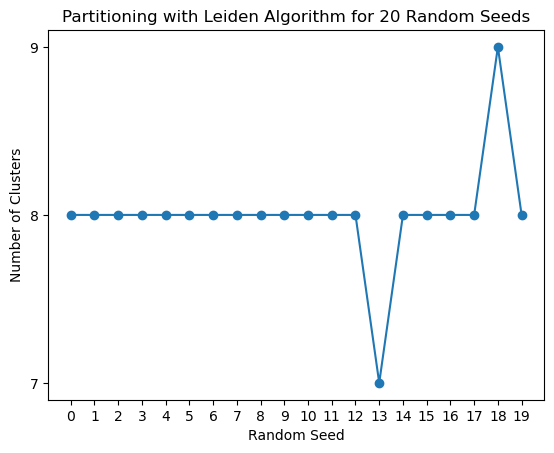

In [20]:
from lib.crisp_partition import leiden as leiden_seed

num_seeds = 20 # results for 1000 seeds include even 10 clusters
seeds = range(num_seeds)

# list to store number of clusters for all seeds
num_communities = []
all_communities = []

for seed in seeds:
    #randseed = np.random.RandomState(seed=seed)  # Set the random seed for reproducibility # problematic since we are not using it again within the function
    #coms = algorithms.leiden(Ggmuer, weights='weight')
    coms = leiden_seed(Ggmuer, weights='weight', seed=seed)
    num_communities.append(len(coms.communities))
    all_communities.append(coms)#.communities)

plt.plot(seeds, num_communities, marker='o')
plt.yticks(range(7,10))
plt.xticks(range(0,20))
plt.xlabel('Random Seed')
plt.ylabel('Number of Clusters')
plt.title('Partitioning with Leiden Algorithm for 20 Random Seeds')
plt.show()

Investigate the number of nodes in each cluster for each of the seeds:

In [13]:
for seed, communities in zip(seeds, all_communities): # zip() function creates an iterator that will merge elements from two or more data sources into one
    print("Seed:", seed)
    for idx, community in enumerate(communities.communities):
        print("Community", idx+1, "Size:", len(community))

Seed: 0
Community 1 Size: 111
Community 2 Size: 107
Community 3 Size: 70
Community 4 Size: 62
Community 5 Size: 52
Community 6 Size: 36
Community 7 Size: 14
Community 8 Size: 8
Seed: 1
Community 1 Size: 113
Community 2 Size: 91
Community 3 Size: 67
Community 4 Size: 56
Community 5 Size: 51
Community 6 Size: 50
Community 7 Size: 24
Community 8 Size: 8
Seed: 2
Community 1 Size: 122
Community 2 Size: 118
Community 3 Size: 62
Community 4 Size: 55
Community 5 Size: 50
Community 6 Size: 36
Community 7 Size: 9
Community 8 Size: 8
Seed: 3
Community 1 Size: 114
Community 2 Size: 108
Community 3 Size: 73
Community 4 Size: 68
Community 5 Size: 51
Community 6 Size: 24
Community 7 Size: 14
Community 8 Size: 8
Seed: 4
Community 1 Size: 111
Community 2 Size: 98
Community 3 Size: 74
Community 4 Size: 56
Community 5 Size: 54
Community 6 Size: 45
Community 7 Size: 14
Community 8 Size: 8
Seed: 5
Community 1 Size: 115
Community 2 Size: 113
Community 3 Size: 67
Community 4 Size: 62
Community 5 Size: 50
Com

In [14]:
# better overview
table_nodes = {} # dictionary for cluster sizes

for seed, communities in zip(seeds, all_communities): # zip() function creates an iterator that merges elements from several data sources into one
    seed_name = f"Seed {seed}" # remember f-strings
    for clusnr, community in enumerate(communities.communities):
        community_name = f"Community {clusnr+1}"
        table_nodes.setdefault(community_name, {})[seed_name] = len(community)

df = pd.DataFrame(table_nodes) # dict into df

print(df)

         Community 1  Community 2  Community 3  Community 4  Community 5  \
Seed 0           111          107           70           62           52   
Seed 1           113           91           67           56           51   
Seed 2           122          118           62           55           50   
Seed 3           114          108           73           68           51   
Seed 4           111           98           74           56           54   
Seed 5           115          113           67           62           50   
Seed 6           118          116           70           63           53   
Seed 7           108          108           76           68           51   
Seed 8           110           92           67           55           51   
Seed 9           116          110           67           57           50   
Seed 10          114          107           69           62           51   
Seed 11          113          111           67           55           52   
Seed 12     

Compare partitions of the Leiden algorithm with different seeds by using cd lib evaluation metrics:

 - embeddedness of a node n w.r.t. a community C is the ratio of its degree within the cluster and its overall degree emb(n,C)=kCn/kn --> high values indicate that a node is well embedded in a community

In [18]:
embeddedness_values = []

for c in all_communities: # all_communities contains the clusterings for all seeds
    embeddedness_value = evaluation.avg_embeddedness(Ggmuer, c)
    embeddedness_values.append(embeddedness_value)

df_embseeds = pd.DataFrame({"Embeddedness": embeddedness_values})

print(df_embseeds)

# results refer to FitnessResult(min=, max=, score=, std=)


                                         Embeddedness
0   (0.09405612339263549, 0.42758201085366865, 0.2...
1   (0.12402918498609955, 0.40750572206026814, 0.2...
2   (0.056037757570060714, 0.45217861190988146, 0....
3   (0.09405612339263549, 0.4304769295293566, 0.25...
4   (0.09405612339263549, 0.41173785042949795, 0.2...
5   (0.05102126158284866, 0.4410282862294968, 0.25...
6   (0.04731134158781021, 0.43576611888263617, 0.2...
7   (0.09405612339263549, 0.4304769295293566, 0.25...
8   (0.12402918498609955, 0.39579118157236637, 0.2...
9   (0.08554201860210567, 0.4392313086827696, 0.25...
10  (0.09405612339263549, 0.43022210528339727, 0.2...
11  (0.05102126158284866, 0.440205752232158, 0.254...
12  (0.05102126158284866, 0.423336780455582, 0.257...
13  (0.12402918498609955, 0.440205752232158, 0.285...
14  (0.09405612339263549, 0.42758201085366865, 0.2...
15  (0.05102126158284866, 0.440205752232158, 0.254...
16  (0.12402918498609955, 0.40331683954689046, 0.2...
17  (0.12402918498609955, 0.

- hub dominance: a hub is a node that has a significantly higher number of connections or links compared to other nodes in the network; critical / influencial nodes; defined as the ratio of the degree of its most connected node w.r.t. the theoretically maximal degree within the community. extent to which a few highly connected nodes, known as hubs, dominate the network.

In [16]:
hub_values = []

for c in all_communities:
    hub_value = evaluation.hub_dominance(Ggmuer, c)
    hub_values.append(hub_value)

df_hub = pd.DataFrame({"Hub Dominance": hub_values})


print(df_hub)
# results refer to FitnessResult(min=, max=, score=, std=)

                                        Hub Dominance
0   (0.8260869565217391, 1.0, 0.9746894409937888, ...
1   (0.8333333333333334, 1.0, 0.9682971014492754, ...
2   (0.8360655737704918, 1.0, 0.9687939110070258, ...
3   (0.7916666666666666, 1.0, 0.963088768115942, 0...
4   (0.7945205479452054, 1.0, 0.9657923412204235, ...
5   (0.8333333333333334, 1.0, 0.9755952380952382, ...
6   (0.8260869565217391, 1.0, 0.9673913043478262, ...
7   (0.7866666666666666, 1.0, 0.9541025641025641, ...
8   (0.8333333333333334, 1.0, 0.9599358974358975, ...
9   (0.8333333333333334, 1.0, 0.9594298245614035, ...
10  (0.8382352941176471, 1.0, 0.9761029411764706, ...
11  (0.8333333333333334, 1.0, 0.9652777777777778, ...
12  (0.8636363636363636, 1.0, 0.9799057649667406, ...
13  (0.8360655737704918, 1.0, 0.9615432022679651, ...
14  (0.8333333333333334, 1.0, 0.9755952380952382, ...
15  (0.8260869565217391, 1.0, 0.9746894409937888, ...
16  (0.8285714285714286, 1.0, 0.9677018633540373, ...
17  (0.8333333333333334, 1.0

- modularity: high modularity score indicates that the network is divided into distinct and well-separated clusters; Z-modularity is another variant of the standard modularity proposed to avoid the resolution limit

In [17]:
zmod_values = []

for c in all_communities:
    zmod_value = evaluation.z_modularity(Ggmuer, c)
    zmod_values.append(zmod_value)

df_zmod = pd.DataFrame({"Modularity (Z-score-based)": zmod_values})


print(df_zmod)
# results refer to modularity score on third position

                 Modularity (Z-score-based)
0   (None, None, 0.27040716063425413, None)
1    (None, None, 0.2625784369626733, None)
2    (None, None, 0.2561352550488741, None)
3    (None, None, 0.2691263651090001, None)
4    (None, None, 0.2782730829047211, None)
5    (None, None, 0.2632681219653706, None)
6   (None, None, 0.26363964815381646, None)
7    (None, None, 0.2676537347757525, None)
8    (None, None, 0.2604448259895957, None)
9     (None, None, 0.258914127885439, None)
10  (None, None, 0.27150975560170876, None)
11   (None, None, 0.2700553562346577, None)
12  (None, None, 0.27901004612592384, None)
13   (None, None, 0.2699608367770122, None)
14   (None, None, 0.2688974404626984, None)
15   (None, None, 0.2694555157824116, None)
16   (None, None, 0.2643757050952666, None)
17   (None, None, 0.2604448259895957, None)
18  (None, None, 0.25040365510025103, None)
19  (None, None, 0.26932921870635673, None)


Visualization of Scores

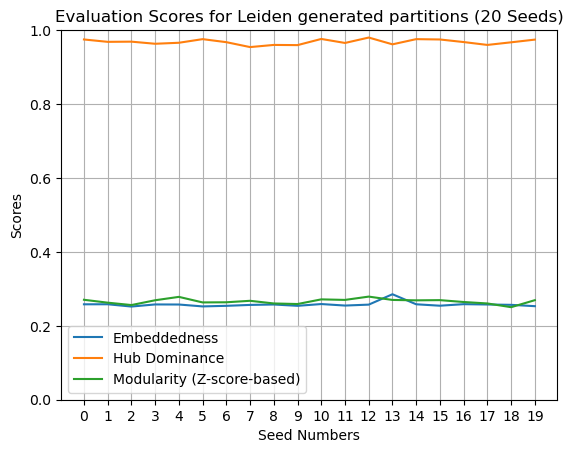

In [22]:
seeds = list(range(num_seeds))

embeddedness_scores = [c[2] for c in embeddedness_values] # taking the third value of the results (tuple)
hub_scores = [c[2] for c in hub_values]
modularity_scores = [c[2] for c in zmod_values]

plt.plot(seeds, embeddedness_scores, label='Embeddedness')
plt.plot(seeds, hub_scores, label='Hub Dominance')
plt.plot(seeds, modularity_scores, label='Modularity (Z-score-based)')

plt.xlabel('Seed Numbers')
plt.ylabel('Scores')
plt.title('Evaluation Scores for Leiden generated partitions (20 Seeds)')
plt.xticks(range(0,20)) # stops with 19
plt.ylim(0, 1)
plt.grid(True)
plt.legend()

plt.show()

To assess the quality of the partitions (versions of clusterings) that are generated with 20 seeds, I used the following metrics:

- embeddedness: the ratio of a node's degree within a cluster and its overall degree
- hub dominance: the ratio of the degree of its most connected node w.r.t. the theoretically maximal degree within the cluster
- Z-modularity: a variant of the standard modularity to avoid the resolution limit

The results show that the partition with the highest embeddedness score is the one with 7 clusters and seed = 13. But this might have to do with the concentration of similar nodes and stronger intra-cluster interactions when the network is partitioned into fewer clusters. This would lead to higher connectivity. <br> 
As it seems to be very unlikely for the Leiden algorithm to generate partitions with 7 or 9 (or more) clusters for our network, we are only going to consider partitions with 8 clusters. <ybr>

Seed = 12 yields the highest hub dominance score of 0.9799. This suggests that the network is characterized by a small number of nodes that act as central points of connectivity for this partition. <br>
Apart from the question of seeds, the hub dominance score is very high for all partitions, which is a general hint for individual key publications in our network that are highly connected and critical for their clusters. <br>
Seed = 12 also yields the highest Z-modularity score of 0.2790. This indicates that the network is divided into more distinct and slightly better separated clusters than done by other seeds. Nevertheless, in terms of distinctiveness, the overall modularity scores are rather low and there is still a high level of interconnection between the different clusters.<br>
The strong interconnection would also explain the relatively low embeddedness scores. Seed = 12 does not yield the highest score for embeddedness, but will still be chosen for its network partition. <br> 


Save chosen partition to our network as partition attribute:

In [37]:
pref_partition = leiden_seed(Ggmuer, weights='weight', seed=12)
len(pref_partition.communities) # 8 clusters

# convincing myself that we are generating the same clusters with the same seed
cluster_sizes = {}  # dict to store cluster sizes
for cluster_id, nodes in enumerate(pref_partition.communities):
    cluster_sizes[cluster_id] = len(nodes)

for cluster_id, size in cluster_sizes.items():
    print(f"Cluster {cluster_id}: {size} nodes") # f-strings
# looks good!


Cluster 0: 115 nodes
Cluster 1: 104 nodes
Cluster 2: 67 nodes
Cluster 3: 63 nodes
Cluster 4: 53 nodes
Cluster 5: 42 nodes
Cluster 6: 8 nodes
Cluster 7: 8 nodes


In [39]:
Ggmuer.partition = pref_partition
len(Ggmuer.partition.communities)

8

In [40]:
nx.write_gexf(Ggmuer, 'Ggmuer_partition_seed12.gexf')